<a href="https://colab.research.google.com/github/nikitakaraevv/learning_laplace_beltrami/blob/master/Learning_LBO_FAUST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


## Getting started

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [0]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat, savemat
import matplotlib.pylab as plt
import scipy.sparse as sparse

In [3]:
!pip install path.py;
from path import Path

In [8]:
!git clone https://github.com/nikitakaraevv/learning_laplace_beltrami

Cloning into 'learning_laplace_beltrami'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [0]:
from learning_laplace_beltrami.src import utils

Download the [dataset](http://3dvision.princeton.edu/projects/2014/3DShapeNets/) directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.

In [10]:
!gdown https://drive.google.com/uc?id=1nXYbykUctJn3UY9-yQnOVpW6PaHJhzFF

Downloading...
From: https://drive.google.com/uc?id=1nXYbykUctJn3UY9-yQnOVpW6PaHJhzFF
To: /content/FAUST.mat
1.24GB [00:11, 110MB/s]


In [0]:
data = loadmat('FAUST.mat');

In [12]:
ind = 0
mesh_data = data['Shape'][ind][0][0][0]
verts = mesh_data[0]
faces = mesh_data[1]-1
# Double precision is important here because sometimes we will have really small values
W = torch.DoubleTensor(mesh_data[14].todense(),); print('W:',W.size())
A = torch.DoubleTensor(mesh_data[15].todense()); print('A:',A.size())
φ = torch.DoubleTensor(mesh_data[16]); print('φ:',φ.size())
λ = torch.diag_embed(torch.DoubleTensor(mesh_data[17].squeeze())); print('λ:',λ.size())

W: torch.Size([6890, 6890])
A: torch.Size([6890, 6890])
φ: torch.Size([6890, 200])
λ: torch.Size([200, 200])


In [13]:
torch.abs(W.matmul(φ)-A.matmul(φ.matmul(λ))).sum()

tensor(0.0043, dtype=torch.float64)

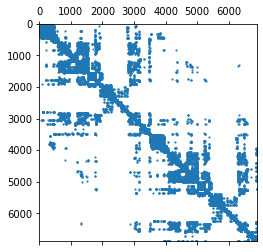

In [14]:
plt.spy(W, markersize=1)

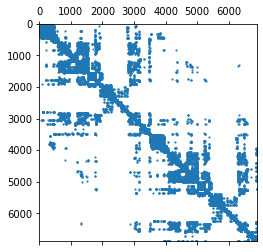

In [15]:
plt.spy(A, markersize=1)

In [16]:
if (W!=W.t()).sum()==0:
    print("W is symmetric")
if (A!=A.t()).sum()==0:
    print("A is symmetric")

W is symmetric
A is symmetric


This dataset consists of **.off** files that contain meshes represented by *vertices* and *triangular faces*. 

We will need a function to read this type of files:

In [0]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

Don't be afraid of this huge function. It's  just to display animated rotation of meshes and point clouds.

In [18]:
utils.visualize_rotate([go.Mesh3d(x=x, y=z, z=y, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

This mesh definitely looks like a bed.

First things first, let's write a function to accurately visualize point clouds so we could see vertices better.

In [20]:
utils.pcshow(x,z,y)

## Transforms

As we want it to look more like a real bed, let's write a function to sample points on the surface uniformly.

 ### Sample points

In [0]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [0]:
pointcloud = PointSampler(6890)((verts, faces))

In [23]:
utils.pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

Unit sphere

In [0]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [0]:
norm_pointcloud = Normalize()(pointcloud)

In [26]:
utils.pcshow(*norm_pointcloud.T)

Notice that axis limits have changed.

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [0]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [0]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [29]:
utils.pcshow(*noisy_rot_pointcloud.T)

### ToTensor

In [0]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.DoubleTensor(pointcloud)

In [28]:
ToTensor()(noisy_rot_pointcloud)

tensor([[ 5.7768e-03, -4.0836e-02,  1.6799e-01],
        [ 4.7145e-01, -3.5834e-01,  3.0866e-04],
        [-7.7410e-01,  4.2951e-01,  1.7033e-01],
        ...,
        [ 3.2247e-01, -2.5234e-01,  5.6041e-03],
        [ 6.7899e-01, -4.0172e-01, -6.7073e-02],
        [-4.8296e-02,  7.7600e-02, -6.0084e-02]], dtype=torch.float64)

In [0]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(6890),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [0]:
class PointCloudData(Dataset):
    def __init__(self, data, valid=False, transform=default_transforms()):
        self.data = data
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid

    def __len__(self):
        return len(self.data)

    def __preproc__(self, verts, faces):
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        mesh_data = self.data[idx][0][0][0]
        verts = mesh_data[0]
        faces = mesh_data[1]-1

        # Double precision is important here because sometimes we will have really small values
        #W = torch.DoubleTensor(mesh_data[14].todense(),)
        #A = torch.DoubleTensor(mesh_data[15].todense())
        φ = torch.DoubleTensor(mesh_data[16])
        λ = torch.diag_embed(torch.DoubleTensor(mesh_data[17].squeeze()))
        
        

        pointcloud = self.__preproc__(verts, faces)
        return {'pointcloud': pointcloud, 
                'φ': φ,
                'φλ': φ.matmul(λ) }

Transforms for training. 1024 points per cloud as in the paper!

In [0]:
train_ds = PointCloudData(data['Shape'][:80])
valid_ds = PointCloudData(data['Shape'][80:], valid=True)

In [38]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

Train dataset size:  80
Valid dataset size:  20
Sample pointcloud shape:  torch.Size([6890, 3])


In [0]:
train_loader = DataLoader(dataset=train_ds, batch_size=4, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=4)

## Model

In [35]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim


class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat


class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

class PointNetReg(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetReg, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu( self.bn1(self.conv1(x)))
        x = F.relu( self.bn2(self.conv2(x)))
        x = F.relu( self.bn3(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.contiguous()
        
        #aa = torch.ones(n_pts);aa[0] = 0;
        #bb = torch.zeros(n_pts);bb[0]=1;
        #x = F.relu(x*aa) + x*bb;
        
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat    

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

if __name__ == '__main__':
    sim_data = Variable(torch.rand(2,3,6890))
    trans = STN3d()
    out = trans(sim_data)
    print('stn', out.size())
    print('loss', feature_transform_regularizer(out))

    sim_data_64d = Variable(torch.rand(32, 64, 2500))
    trans = STNkd(k=64)
    out = trans(sim_data_64d)
    print('stn64d', out.size())
    print('loss', feature_transform_regularizer(out))

    pointfeat = PointNetfeat(global_feat=True)
    out, _, _ = pointfeat(sim_data)
    print('global feat', out.size())

    pointfeat = PointNetfeat(global_feat=False)
    out, _, _ = pointfeat(sim_data)
    print('point feat', out.size())

    cls = PointNetCls(k = 5)
    out, _, _ = cls(sim_data)
    print('class', out.size())

    seg = PointNetDenseCls(k = 3)
    out, _, _ = seg(sim_data)
    print('seg', out.size())
    
    reg = PointNetReg(k = 1)
    out, _, _ = reg(sim_data)
    print('reg', out.size())


stn torch.Size([2, 3, 3])
loss tensor(2.1267, grad_fn=<MeanBackward0>)
stn64d torch.Size([32, 64, 64])
loss tensor(128.4412, grad_fn=<MeanBackward0>)
global feat torch.Size([2, 1024])
point feat torch.Size([2, 1088, 6890])
class torch.Size([2, 5])
seg torch.Size([2, 6890, 3])
reg torch.Size([2, 6890, 1])


## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [0]:
weightNet = PointNetReg(k = 1, feature_transform = False).to(device) 
optimizer = optim.Adam(weightNet.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.75)


In [0]:
batch = next(iter(train_loader))
pcd, φ, φλ = batch['pointcloud'], batch['φ'], batch['φλ']

In [44]:
pcd.size()

torch.Size([4, 6890, 3])

In [0]:
pointnet = PointNet()
pointnet.to(device);

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [0]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)".pth")

In [0]:
train(pointnet, train_loader, valid_loader,  save=False)

[1,    10 /    125] loss: 0.778
[1,    20 /    125] loss: 0.834
[1,    30 /    125] loss: 0.763
[1,    40 /    125] loss: 0.793
[1,    50 /    125] loss: 0.740
[1,    60 /    125] loss: 0.679
[1,    70 /    125] loss: 0.780
[1,    80 /    125] loss: 0.826
[1,    90 /    125] loss: 0.906
[1,   100 /    125] loss: 0.670
[1,   110 /    125] loss: 0.670
[1,   120 /    125] loss: 0.614
Valid accuracy: 56 %
[2,    10 /    125] loss: 0.752
[2,    20 /    125] loss: 0.673
[2,    30 /    125] loss: 0.572
[2,    40 /    125] loss: 0.643
[2,    50 /    125] loss: 0.724
[2,    60 /    125] loss: 0.648
[2,    70 /    125] loss: 0.575
[2,    80 /    125] loss: 0.619
[2,    90 /    125] loss: 0.666
[2,   100 /    125] loss: 0.750
[2,   110 /    125] loss: 0.578
[2,   120 /    125] loss: 0.488
Valid accuracy: 72 %
[3,    10 /    125] loss: 0.578
[3,    20 /    125] loss: 0.545
[3,    30 /    125] loss: 0.672
[3,    40 /    125] loss: 0.611
[3,    50 /    125] loss: 0.607
[3,    60 /    125] loss: 0.50

KeyboardInterrupt: ignored

## Test

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth'))
pointnet.eval();

In [0]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        


Batch [   0 /   15]
Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]


In [0]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[40, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 95,  2,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  1, 99,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  2, 35,  6,  0, 17,  5, 17,  1],
       [ 0,  0,  0,  0, 42,  0, 43,  0,  1,  0],
       [ 0,  0,  1,  0, 22, 75,  2,  0,  0,  0],
       [ 0,  0,  1,  0,  6,  0, 78,  0,  1,  0],
       [ 0,  1,  1,  0,  1,  0,  1, 96,  0,  0],
       [ 0,  0,  0,  6,  0,  0,  1,  0, 93,  0],
       [ 1,  0, 15,  0,  1,  0,  2,  1,  0, 80]])

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


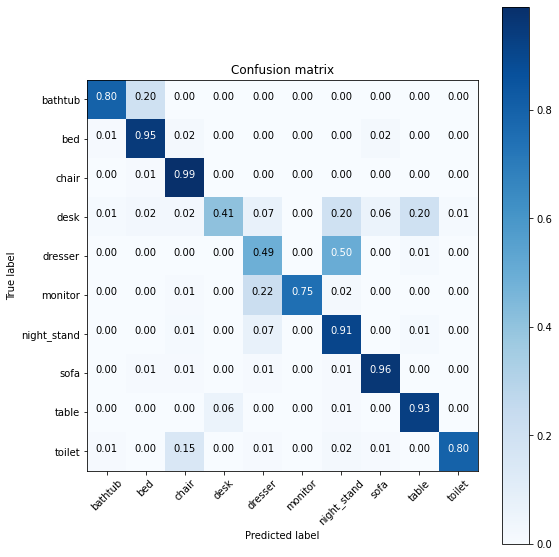

In [0]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


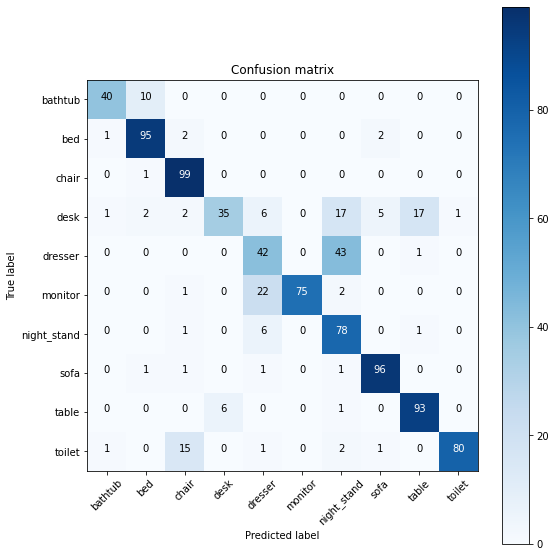

In [0]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)